In [1]:
import os
import re
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# os.chdir('..')
os.chdir(os.path.expanduser("~/nope/clm"))

In [3]:
# fig_vis_head_entro
exps: list[str] = [
    "NoPE50k(4k)",
    "NoPE50k_s1.2(4k)",
    "NoPE50k_HS4k(4k)",
]

In [4]:
ent_root = Path("ckpts_arxiv/llama_eval_entropy/runs/")
if not ent_root.exists():
    raise Exception("Path does not exist: {}".format(ent_root))
# get all folders in root_folder
folders = ent_root.iterdir()


# filter using exps
def filter_name(p: Path):
    return any(p.name.startswith(f"{exp}|") for exp in exps)


folders = sorted([f for f in folders if filter_name(f)])
pattern = re.compile(r"^([^|]+).*")
ent_lines: dict[str, Path] = {pattern.match(path.name).group(1): path for path in folders}
print(ent_lines)

{'NoPE50k(4k)': PosixPath('ckpts_arxiv/llama_eval_entropy/runs/NoPE50k(4k)|Feb14_22-57-11'), 'NoPE50k_HS4k(4k)': PosixPath('ckpts_arxiv/llama_eval_entropy/runs/NoPE50k_HS4k(4k)|Feb15_11-18-32'), 'NoPE50k_s1.2(4k)': PosixPath('ckpts_arxiv/llama_eval_entropy/runs/NoPE50k_s1.2(4k)|Feb14_23-08-19')}


In [7]:
def load_ent(path: Path):
    arr: np.ndarray = np.load(path / "entropy.npy").astype(np.float32)
    n_layers, n_heads, seq_len = arr.shape
    data = []
    for i in range(n_layers):
        for j in range(n_heads):
            for k in range(seq_len):
                data.append(
                    {
                        "layer": i,
                        "head": j,
                        "Position": k,
                        "Entropy": arr[i, j, k],
                    }
                )
    df = pd.DataFrame(data)
    return df

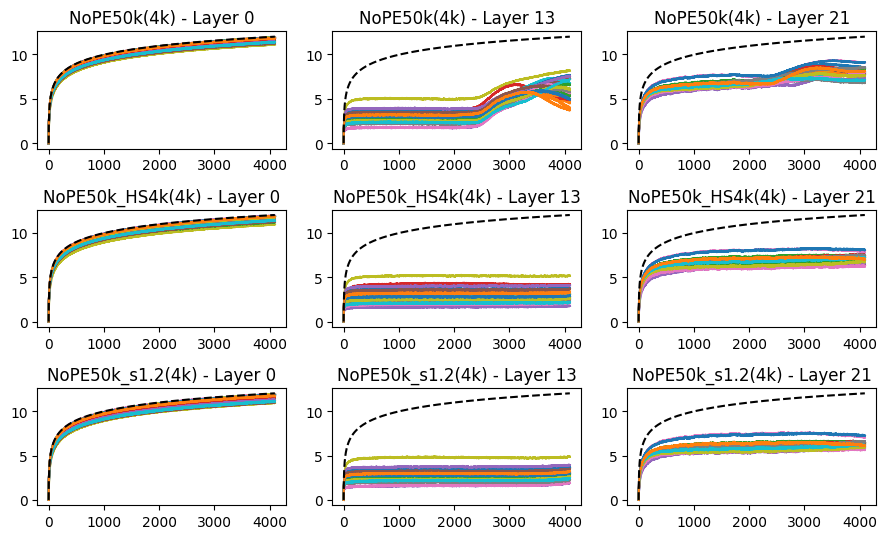

In [42]:
layers = [0, 13, 21]
# heads = list(range(10))
heads = list(range(22))
# A4_paper_size_inches = (8.27, 11.69)
# fig_size = list(size / 2 for size in A4_paper_size_inches)
fig, axs = plt.subplots(3, 3, figsize=(9, 5.5))
for i, (name, path) in enumerate(ent_lines.items()):
    df = load_ent(path)
    for j, layer in enumerate(layers):
        plot_df = df[df["layer"] == layer][df["head"].isin(heads)]
        sns.lineplot(data=plot_df, ax=axs[i][j], x="Position", y="Entropy", hue="head", legend=False, palette="tab10")
        axs[i][j].set_title(f"{name} - Layer {layer}")
        x = np.arange(0, 4096)
        y = np.log2(x + 1)
        axs[i][j].plot(x, y, color="black", linestyle="dashed")
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')
fig.tight_layout()  # to ensure that the right y-label is not slightly clipped

In [40]:
fig.savefig(os.path.join("logs", "fig.pdf"))
# plt.savefig(os.path.join("logs", "loss.png"))